# Simple Video Pipeline Reading From Multiple Files 

### Goal
In this example, we will go through the creation of a pipeline using the [readers.video](../../../supported_ops.html#nvidia.dali.fn.readers.video) operator.
The pipeline will return a batch of frame sequences. These sequences are an arbitrary number of frames (images). The difference being that images are or dimension `HWC` whereas sequences are of dimension `FHWC`.

For more information on the [readers.video](../../../supported_ops.html#nvidia.dali.fn.readers.video) parameters, please look at the documentation.

## Setting Up

First let's start with the imports:

In [1]:
import os
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

We need some video containers to process. We can use [Sintel](https://en.wikipedia.org/wiki/Sintel) trailer, which is an mp4 container containing an h264 video and distributed under the Create Common license. Let's split it into 10s clips in order to check how `readers.Video` handles multiple video files. This can be done easily with the `ffmpeg` standalone tool. 

Then we can set the parameters that will be use in the pipeline. The `count` parameter will define how many frames we want in each sequence sample.

We can replace `video_directory` with any other directory containing video container files recognized by **FFmpeg**.

In [2]:
batch_size=2
sequence_length=8
initial_prefetch_size=16
video_directory = os.path.join(os.environ['DALI_EXTRA_PATH'], "db", "video", "sintel", "video_files")
video_files=[video_directory + '/' + f for f in os.listdir(video_directory)]
n_iter=6

**Note**: `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out. 

## Running the Pipeline

We can then define a minimal pipeline that will output directly the [readers.video](../../../supported_ops.html#nvidia.dali.fn.readers.video) outputs:

In [3]:
@pipeline_def
def video_pipe(filenames):
    videos = fn.readers.video(device="gpu", filenames=filenames, sequence_length=sequence_length,
                              shard_id=0, num_shards=1, random_shuffle=True, initial_fill=initial_prefetch_size)
    return videos

Caution: One important here is tuning `initial_fill`, that correspond to the reader prefetch buffer initial size. Since this buffer will be filled of `initial_fill` sequences, the total number of frames can be really huge! So set it consequently to not OOM during training.

Let's try to build and run a `video_pipe` on device 0 that will output `batch_size` sequences of `count` frames at each iteration.


In [9]:
pipe = video_pipe(batch_size=batch_size, num_threads=2, device_id=0, filenames=video_files, seed=123456)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)


### Visualizing the Results

The previous iterations seems to have the yield batches of the expected shape. We will use matplotlib to display the frames we obtained in the last batch.

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [11]:
def show_sequence(sequence):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

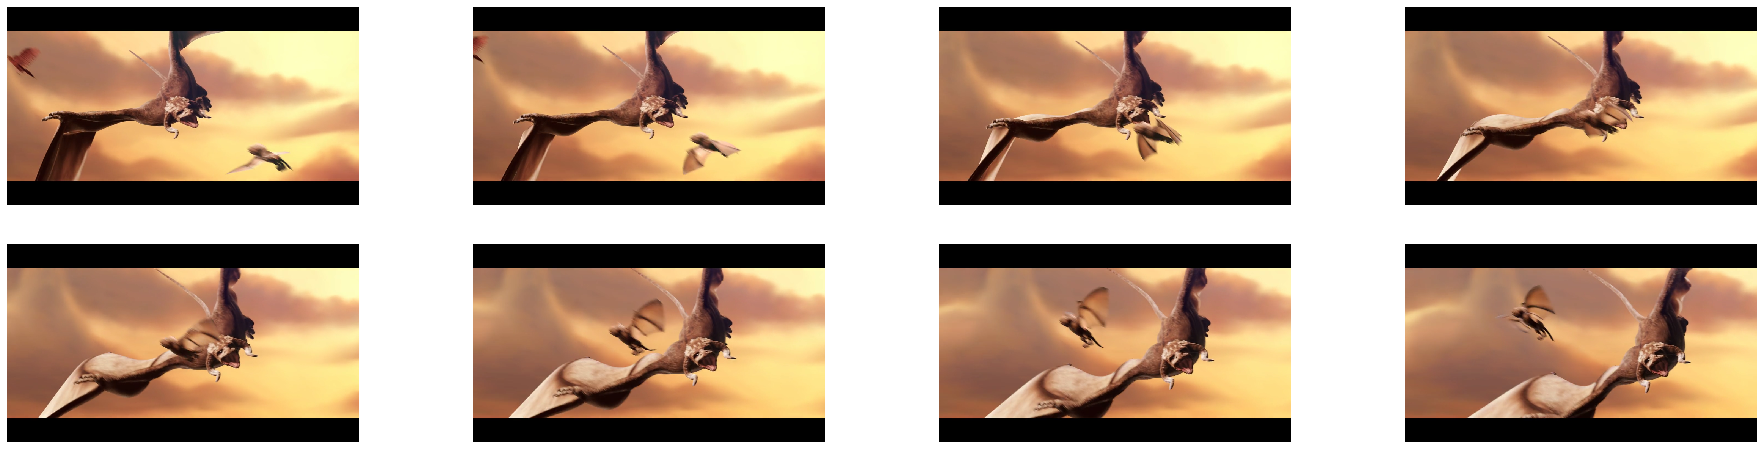

In [12]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[0])